# Code Challenge - Autoencoder - How many units

In [38]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = np.loadtxt(open('../data/mnist_train_small.csv', 'rb'), delimiter=',')

labels = data[:, 0]
data = data[:, 1:]

# normalizing data to a range of 0-1

dataNorm = data/np.max(data)

dataT = torch.tensor(dataNorm).float()

In [19]:
def createMNISTAE(enc, bn):
    
    class AENet(nn.Module):
        def __init__(self):
            super().__init__()
            self.ip = nn.Linear(784, enc) # input layer
            self.enc = nn.Linear(enc, bn) # encoder layer
            self.lat = nn.Linear(bn, enc) # latent layer
            self.dec = nn.Linear(enc, 784) # decoder layer - op is same as ip
        
        def forward(self, x):
            x = F.relu(self.ip(x))
            x = F.relu(self.enc(x))
            x = F.relu(self.lat(x))
            return torch.sigmoid(self.dec(x)) # as ip data is in 0-1, op should be in same numerical range as ip
            
    net = AENet()
    
    lossfn = nn.MSELoss()
    optim = torch.optim.Adam(net.parameters(), lr=.001)
    
    return net, lossfn, optim

In [51]:
def trainModel(enc, bn):
    nEp = 3

    net, lossfn, optim = createMNISTAE(enc, bn)
    losses = []
    
    bs = 32 # batch size
    numBatches = int(dataT.shape[0]/bs)

    for i in range(nEp):
        randIdx = np.random.permutation(dataT.shape[0]).astype(int) # slecting a random set of images
        
        batchLosses = []
        
        for bi in range(numBatches):
            
            # non-overlapping samples to use in this batch
            samps2use = range((bi-1)*bs,bi*bs)
            
            X = dataT[randIdx[samps2use], :]
            
            
            # forward pass
            yH = net(X)
            loss = lossfn(yH, X) # data itself is a label

            # backprop
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLosses.append(loss.item())

        losses.append(np.mean(batchLosses[-3:]))

    return losses, net

In [53]:
# Parametric Exp

enc = np.linspace(10, 500, 12).astype(int) # encoding-decoding units
bn = np.linspace(5, 100, 8).astype(int) # bottleneck units
lossRes = np.zeros((len(enc), len(bn)))
for i, e in enumerate(enc):
    for j, b in enumerate(bn):
        losses, net = trainModel(e, b)
        lossRes[i, j] = np.mean(losses[-1])
        
        # status updation
        currIter = i*len(bn) + j + 1
        totalIter = len(bn)*len(enc)
        msg = "Finished experiment {}/{}".format(currIter, totalIter)
        sys.stdout.write('\r' + msg) # \r - go in reverse (delete entire line and go back to beginning of line)

Finished experiment 96/96

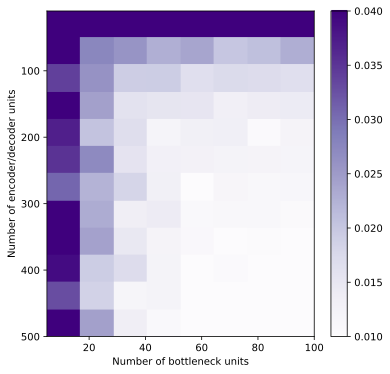

In [54]:
# show the results matrix
fig = plt.figure(figsize=(6,6))

plt.imshow(lossRes,aspect='auto',         # data and aspect ratio
           vmin=.01,vmax=.04, cmap='Purples', # color range and palette
           extent=[ bn[0],bn[-1],enc[-1],enc[0], ]) # xy axis ticks
           

plt.xlabel('Number of bottleneck units')
plt.ylabel('Number of encoder/decoder units')
plt.colorbar()

plt.show()

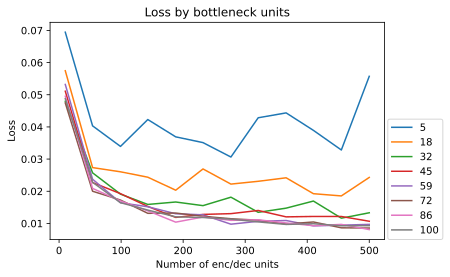

In [55]:
# perhaps a line plot will better reveal the sudden transition

plt.plot(enc,lossRes)
plt.legend(bn,loc=(1.01,0))
plt.xlabel('Number of enc/dec units')
plt.title('Loss by bottleneck units')
plt.ylabel('Loss')
plt.show()

# Code Challenge - Implementation on GPU

Change below code to work on GPU, and get data back to CPU whenever required

In [12]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# import dataset (comes with colab!)
data = np.loadtxt(open('../data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# Create train/test groups using DataLoader

# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

/tmp/ipykernel_7475/4236952429.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [13]:
# Create the DL model

# create a class for the model
def createTheMNISTNet(nUnits,nLayers):

  class mnistNet(nn.Module):
    def __init__(self,nUnits,nLayers):
      super().__init__()

      # create dictionary to store the layers
      self.layers = nn.ModuleDict()
      self.nLayers = nLayers

      ### input layer
      self.layers['input'] = nn.Linear(784,nUnits)
      
      ### hidden layers
      for i in range(nLayers):
        self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)

      ### output layer
      self.layers['output'] = nn.Linear(nUnits,10)
    


    # forward pass
    def forward(self,x):
      # input layer (note: the code in the video omits the relu after this layer)
      x = F.relu( self.layers['input'](x) )

      # hidden layers
      for i in range(self.nLayers):
        x = F.relu( self.layers[f'hidden{i}'](x) )
      
      # return output layer
      x = self.layers['output'](x)
      return x
  
  # create the model instance
  net = mnistNet(nUnits,nLayers)
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [14]:
# Generate an instance of the model and confirm that it returns the expected network.
nUnitsPerLayer = 12
nLayers = 4
net = createTheMNISTNet(nUnitsPerLayer,nLayers)
net

# Create a function that trains the model

# a function that trains the model

def funtion2trainTheModel(nUnits,nLayers):

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet(nUnits,nLayers)

  net.to(device)

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:
      
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      
      yHat = yHat.cpu()
      y = y.cpu()
      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct.cpu() )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    yHat = yHat.cpu()
    y = y.cpu()
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

Finished units 1/5 and layers 1/3
Finished units 1/5 and layers 2/3
Finished units 1/5 and layers 3/3
Finished units 2/5 and layers 1/3
Finished units 2/5 and layers 2/3
Finished units 2/5 and layers 3/3
Finished units 3/5 and layers 1/3
Finished units 3/5 and layers 2/3
Finished units 3/5 and layers 3/3
Finished units 4/5 and layers 1/3
Finished units 4/5 and layers 2/3
Finished units 4/5 and layers 3/3
Finished units 5/5 and layers 1/3
Finished units 5/5 and layers 2/3
Finished units 5/5 and layers 3/3


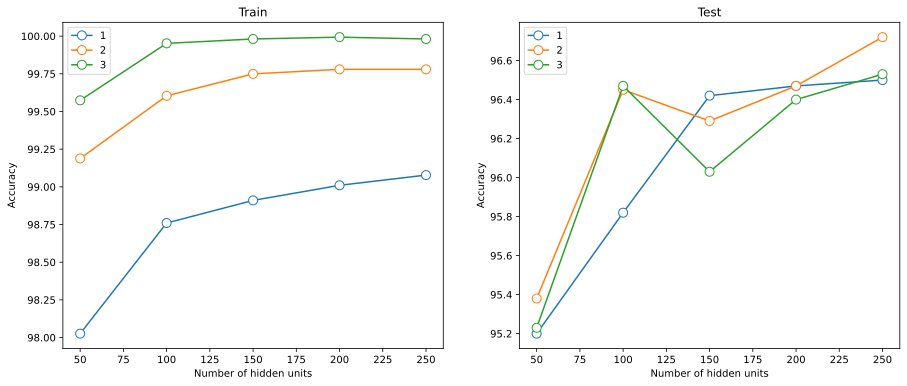

In [15]:
# Run the model and show the results!

### run the experiment! (note: takes ~30 mins)

# define the model parameters
numlayers = range(1,4)           # number of hidden layers
numunits  = np.arange(50,251,50) # units per hidden layer

# initialize output matrices
accuracies  = np.zeros((2,len(numunits),len(numlayers)))

# start the experiment!
for unitidx in range(len(numunits)):
  for layeridx in range(len(numlayers)):

    # create and train a fresh model
    trainAcc,testAcc,losses,net = funtion2trainTheModel(numunits[unitidx],numlayers[layeridx])

    # store the results (average of final 5 epochs)
    accuracies[0,unitidx,layeridx] = np.mean(trainAcc[-5:])
    accuracies[1,unitidx,layeridx] = np.mean(testAcc[-5:])

    # print a friendly status message
    print(f'Finished units {unitidx+1}/{len(numunits)} and layers {layeridx+1}/{len(numlayers)}') 


# show accuracy as a function of model depth
fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(numunits,accuracies[0,:,:],'o-',markerfacecolor='w',markersize=9)
ax[1].plot(numunits,accuracies[1,:,:],'o-',markerfacecolor='w',markersize=9)

for i in range(2):
  ax[i].legend(numlayers)
  ax[i].set_ylabel('Accuracy')
  ax[i].set_xlabel('Number of hidden units')
  ax[i].set_title([ 'Train' if i==0 else 'Test' ][0])

plt.show()

# Code Challenge - Convolution - Choosing parameters

In [16]:
# import libraries
import numpy as np
import torch
import torch.nn as nn

## Sample problem

### Convolve an image of size 1x256x256 to produce a 1x252x84 result

In [17]:
# parameters
inChans  = 1 # RGB
imsize   = [256,256]
outChans = 1
krnSize  = 7 # should be an odd number
stride   = (1,3)
padding  = 1

# create the instance
c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)

# create an image
img = torch.rand(1,inChans,imsize[0],imsize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans,0,0],dtype=int)
expectSize[1] = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imsize[1]+2*padding-krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Expected size: [  1 252  84]
Empirical size: [252, 84]


### 1) Convolve an image of size 3x64x64 to produce a 10x28x28 result

In [66]:
# parameters
inChans  = 3
imsize   = [64, 64]
outChans = 10
krnSize  = 9
stride   = (2,2)
padding  = 0

# create the instance
c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)

# create an image
img = torch.rand(1,inChans,imsize[0],imsize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans,0,0],dtype=int)
expectSize[1] = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imsize[1]+2*padding-krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Expected size: [10 28 28]
Empirical size: [10, 28, 28]


### 2) Convolve an image of size 3x196x96 to produce a 5x66x49 result

In [71]:
# parameters
inChans  = 3
imsize   = [196, 96]
outChans = 5
krnSize  = 3
stride   = (3,2)
padding  = 2

# create the instance
c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)

# create an image
img = torch.rand(1,inChans,imsize[0],imsize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans,0,0],dtype=int)
expectSize[1] = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imsize[1]+2*padding-krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Expected size: [ 5 66 49]
Empirical size: [5, 66, 49]


### 3) Convolve an image of size 1x32x32 to produce a 6x28x28 result

In [72]:
# parameters
inChans  = 1
imsize   = [32, 32]
outChans = 6
krnSize  = 5
stride   = (1,1)
padding  = 0

# create the instance
c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)

# create an image
img = torch.rand(1,inChans,imsize[0],imsize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans,0,0],dtype=int)
expectSize[1] = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imsize[1]+2*padding-krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Expected size: [ 6 28 28]
Empirical size: [6, 28, 28]


### 4) Convolve an image of size 3x227x227 to produce a 96x55x55 result

In [85]:
# parameters
inChans  = 3
imsize   = [227, 227]
outChans = 96
krnSize  = 9
stride   = (4,4)
padding  = 0

# create the instance
c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)

# create an image
img = torch.rand(1,inChans,imsize[0],imsize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans,0,0],dtype=int)
expectSize[1] = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imsize[1]+2*padding-krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Expected size: [96 55 55]
Empirical size: [96, 55, 55]


### 5) Convolve an image of size 3x224x224 to produce a 64x224x224 result

In [87]:
# parameters
inChans  = 3
imsize   = [224, 224]
outChans = 64
krnSize  = 3
stride   = (1,1)
padding  = 1

# create the instance
c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)

# create an image
img = torch.rand(1,inChans,imsize[0],imsize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans,0,0],dtype=int)
expectSize[1] = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imsize[1]+2*padding-krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Expected size: [ 64 224 224]
Empirical size: [64, 224, 224]


# Code Challenge - CNN - Softcoding vs Hardcoding

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

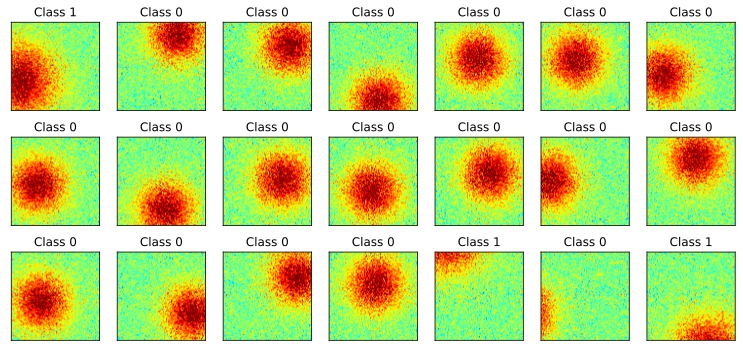

In [2]:
npc = 1000 # number of points per class
imgSize = 91 # 91x91 image

x = np.linspace(-4,4,imgSize) 
X,Y = np.meshgrid(x,x)

# sigma (arbitrary units)
widths = [1.8, 2.4]

# initializing tensors containing images and labels
imgs = torch.zeros(2*npc, 1, imgSize, imgSize)
labels = torch.zeros(2*npc)

for i in range(2*npc):
    
    # creating gaussians with random centers
    ro = 2*np.random.randn(2) # random offset
    G = np.exp(-((X - ro[0])**2 + (Y-ro[1])**2)/ (2*widths[i%2]**2))
    
    # add noise
    G += np.random.randn(imgSize, imgSize)/5
    
    # adding to tensor
    imgs[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
    labels[i] = i%2
    
labels = labels[:, None]

# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(2*npc)
    G = np.squeeze( imgs[whichpic,:,:] )
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
    ax.set_title('Class %s'%int(labels[whichpic].item()))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_ds = TensorDataset(X_train, y_train)
test_ds  = TensorDataset(X_test, y_test)

# Step 4: translate into dataloader objects
batchsize    = 32
trainLoader = DataLoader(train_ds,batch_size=batchsize,shuffle=True,drop_last=True)
testLoader  = DataLoader(test_ds,batch_size=test_ds.tensors[0].shape[0])

In [4]:
# Kinda like Hyper-parameters
c1k = (3,2)  # kernel size for convolution 1
c1oc = 6 # out channels for conv 1
c1s = (2,3) # stride for conv1
c1p = 1 # padding for c1
p1 = 2 # pooling size after conv1

c2k = (3,2)   # kernel size for convolution 2
c2oc = 4 # out channels for conv 2
c2s = (2,3) # stride for conv2
c2p = 1 # padding for c2
p2 = 2 # pooling size after conv2

In [5]:
def makeNet():
    class gaussNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            # conv1
            self.conv1 = nn.Conv2d(1, c1oc, kernel_size=c1k, stride=c1s)
            # outsize = (91 + 2*1 - 3)/2 + 1 = 46
            # post-pooling: 46/2 = 23
            temp1W = int((np.floor((imgSize + 2*self.conv1.padding[0] - c1k[0])/c1s[0] + 1))/p1) # post conv and pooling
            temp1H = int((np.floor((imgSize + 2*self.conv1.padding[1] - c1k[1])/c1s[1] + 1))/p1)
            
            # conv2
            self.conv2 = nn.Conv2d(c1oc, c2oc, kernel_size=c2k,stride=c2s)
            # op size = (23 + 2*1 - 2)/3 + 1 = 8
            # post-pooling: 8/2 = 4
            temp2W = int((np.floor((temp1W + 2*self.conv2.padding[0] - c2k[0])/c2s[0] + 1))/p2)
            temp2H = int((np.floor((temp1H + 2*self.conv2.padding[1] - c2k[1])/c2s[1] + 1))/p2)
            
            
            self.fc1 = nn.Linear(temp2W*temp2H*c2oc, 50)
            self.op = nn.Linear(50, 1)
            
        def forward(self, x):
            # first conv-pool
            conv1act = F.relu(self.conv1(x))
            x = F.avg_pool2d(conv1act, (2,2))
            
            # second conv-pool
            conv2act = F.relu(self.conv2(x))
            x = F.avg_pool2d(conv2act, (2,2))
            
            # ANN
            x = x.reshape(x.shape[0], -1)
            x = F.relu(self.fc1(x))
            x = self.op(x)
            
            return x, conv1act, conv2act
        
    
    net = gaussNet()
    lossfn = nn.BCEWithLogitsLoss()
    optim = torch.optim.Adam(net.parameters(), lr=0.001)
    
    return net, lossfn, optim

In [ ]:
# testing model 

net, lossfn, optim = makeNet()

X,y = next(iter(testLoader))
yH, f1, f2 = net(X)  # extract feature maps 1 and 2
loss = lossfn(yH,y)


print(yH.shape, f1.shape, f2.shape)

In [20]:
summary(net, (1, imgSize, imgSize))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [7]:
# function to train model
def trainModel():

    # number of epochs
    numepochs = 10

    # create a new model
    net,lossfun,optimizer = makeNet()

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    trainAcc  = torch.zeros(numepochs)
    testAcc   = torch.zeros(numepochs)
    testLoss  = torch.zeros(numepochs)


    # loop over epochs
    for i in range(numepochs):

        # loop over training data batches
        net.train()
        batchAcc  = []
        batchLoss = []
        for X,y in trainLoader:

            # forward pass and loss
            yHat = net(X)[0]
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())
            batchAcc.append(torch.mean(( (yHat>0) ==y).float()).item())
            # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc[i] = 100*np.mean(batchAcc)
        trainLoss[i] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X,y = next(iter(testLoader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)[0]
            loss = lossfn(yHat, y)

        # compare the following really long line of code to the training accuracy lines
        testAcc[i] = 100*torch.mean(( (yHat>0) ==y).float()).item()
        testLoss[i] = loss.item()

        # end epochs

    # function output
    return net, trainLoss, testLoss, trainAcc, testAcc

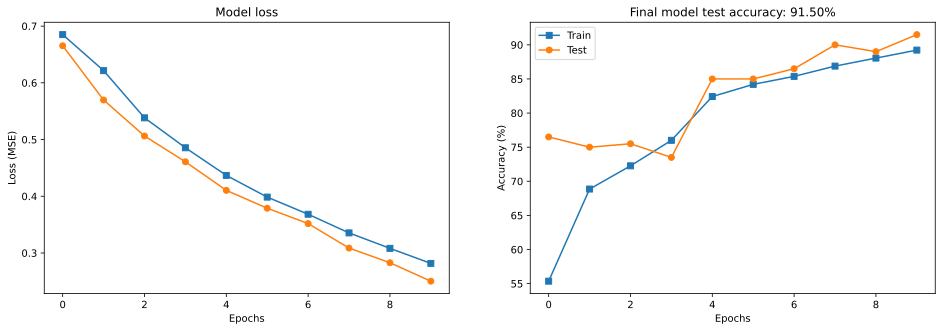

In [8]:
net, trainLoss, testLoss, trainAcc, testAcc = trainModel()

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

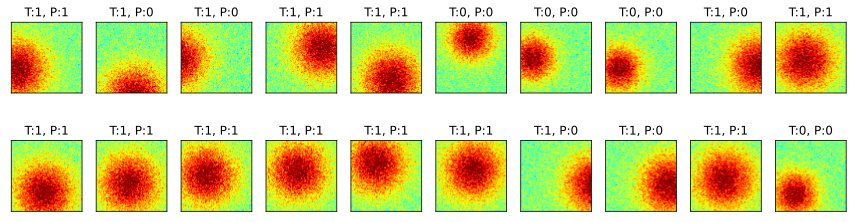

In [9]:
# visualize some images

X,y = next(iter(testLoader)) # extract X,y from test dataloader
yHat, featmap1, featmap2 = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,4))

for i,ax in enumerate(axs.flatten()):
    G = torch.squeeze( X[i,0,:,:] ).detach()
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
    t = ( int(y[i].item()) , int(yHat[i].item()>0) )
    ax.set_title('T:%s, P:%s'%t)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

### Drawing Feature maps

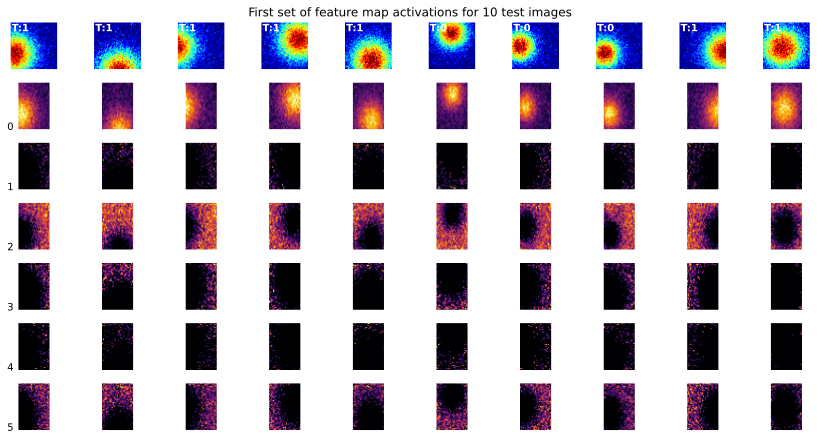

In [10]:
# Feature maps from the conv1 layer

fig,axs = plt.subplots(7,10,figsize=(12,6))

for pici in range(10):

  # show the original picture
    img = X[pici,0,:,:].detach()
    axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
    axs[0,pici].axis('off')
    axs[0,pici].text(2,2,'T:%s'%int(y[pici].item()),ha='left',va='top',color='w',fontweight='bold')

    for feati in range(featmap1.shape[1]):
        # extract the feature map from this image
        img = featmap1[pici,feati,:,:].detach()
        axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=torch.max(img)*.9)
        axs[feati+1,pici].axis('off')
        axs[feati+1,pici].text(-5,45,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('First set of feature map activations for 10 test images',x=.5,y=1.01)
plt.show()

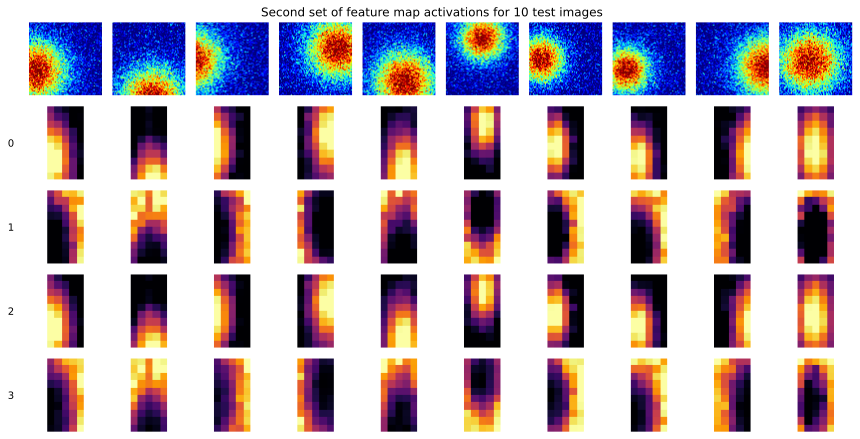

In [16]:
# # Repeat for feature2 maps

fig,axs = plt.subplots(featmap2.shape[1]+1,10,figsize=(12,6))

for pici in range(10):

    # show the original picture
    img = X[pici,0,:,:].detach()
    axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
    axs[0,pici].axis('off')

    for feati in range(featmap2.shape[1]):
        # extract the feature map from this image
        img = featmap2[pici,feati,:,:].detach()
        axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=torch.max(img)*.9)
        axs[feati+1,pici].axis('off')
        axs[feati+1,pici].text(-5,featmap2.shape[2]/2,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('Second set of feature map activations for 10 test images',x=.5,y=1.01)
plt.show()

### Spatial correlation across feature maps

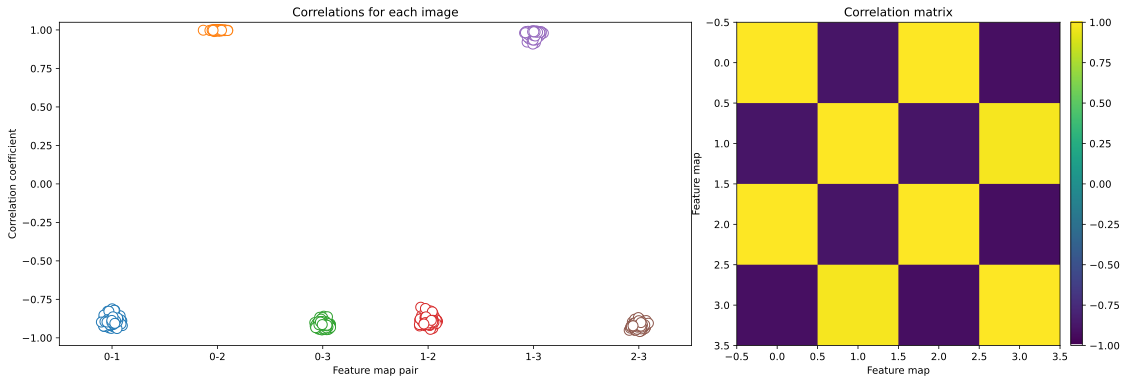

In [12]:
### correlations across the SECOND convolution layer

# convenient variables
nStim = featmap2.shape[0]
nMaps = featmap2.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

    # extract the vectorized feature maps from this image
    featmaps = featmap2[i,:,:,:].view(nMaps,-1).detach()

    # compute the correlation matrix
    C = np.corrcoef(featmaps)
    Call += C

    # extract the unique correlations from the matrix
    idx = np.nonzero(np.triu(C,1))
    allrs[i,:] = C[idx]


# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
    xlab.append('%s-%s' %(idx[0][i],idx[1][i]))




# now visualize the correlations
fig = plt.figure(figsize=(16,5))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.98,.1,.01,.9])

for i in range(nCors):
    ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=10)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


# now show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.show()

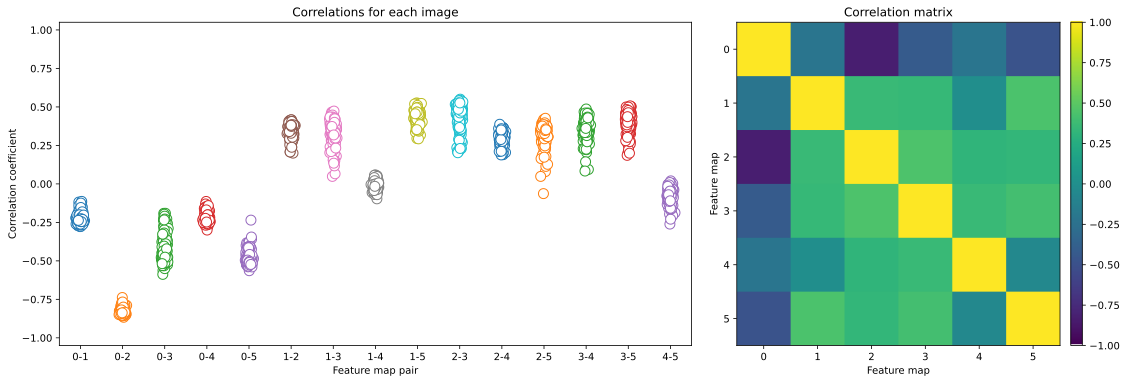

In [13]:
### correlations across the FIRST convolution layer

# convenient variables
nStim = featmap1.shape[0]
nMaps = featmap1.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

    # extract the vectorized feature maps from this image
    featmaps = featmap1[i,:,:,:].view(nMaps,-1).detach()

    # compute the correlation matrix
    C = np.corrcoef(featmaps)
    Call += C

    # extract the unique correlations from the matrix
    idx = np.nonzero(np.triu(C,1))
    allrs[i,:] = C[idx]


# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
    xlab.append('%s-%s' %(idx[0][i],idx[1][i]))


# now visualize the correlations
fig = plt.figure(figsize=(16,5))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.98,.1,.01,.9])

for i in range(nCors):
    ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=10)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


# now show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.show()

# Code Challenge - CNN - How  wide the FC

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
npc = 1000 # number of points per class
imgSize = 91 # 91x91 image

x = np.linspace(-4,4,imgSize) 
X,Y = np.meshgrid(x,x)

# sigma (arbitrary units)
widths = [1.8, 2.4]

# initializing tensors containing images and labels
imgs = torch.zeros(2*npc, 1, imgSize, imgSize)
labels = torch.zeros(2*npc)

for i in range(2*npc):
    
    # creating gaussians with random centers
    ro = 2*np.random.randn(2) # random offset
    G = np.exp(-((X - ro[0])**2 + (Y-ro[1])**2)/ (2*widths[i%2]**2))
    
    # add noise
    G += np.random.randn(imgSize, imgSize)/5
    
    # adding to tensor
    imgs[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
    labels[i] = i%2
    
labels = labels[:, None]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=.2)

# Step 3: convert into PyTorch Datasets
train_ds = TensorDataset(X_train, y_train)
test_ds  = TensorDataset(X_test, y_test)

# Step 4: translate into dataloader objects
batchsize    = 32
trainLoader = DataLoader(train_ds,batch_size=batchsize,shuffle=True,drop_last=True)
testLoader  = DataLoader(test_ds,batch_size=test_ds.tensors[0].shape[0])

In [20]:
def makeNet(nUnits=50):
    class gaussNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.layers = nn.Sequential(
                nn.Conv2d(1,6,3,padding=1), # op size = (91+2*1-3)/1 + 1 = 91
                nn.ReLU(),
                nn.AvgPool2d(2,2), # op size = 91/2 = 45
                
                nn.Conv2d(6,4,3,padding=1), # op size = (45+2*1-3)/1 + 1 = 45
                nn.ReLU(),
                nn.AvgPool2d(2,2), # op size = 45/2 = 22
                
                nn.Flatten(),  # vectorizing conv op 
                nn.Linear(22*22*4,  nUnits), # op size = 50
                nn.ReLU(),
                nn.Linear(nUnits,  nUnits//2),
                nn.ReLU(),
                nn.Linear(nUnits//2, 1) # op size = 1
            )
        
        def forward(self, x):
            return self.layers(x)
        
    
    net = gaussNet()
    
    lossfn = nn.BCEWithLogitsLoss()
    
    optim = torch.optim.Adam(net.parameters(), lr = 0.001)
    
    return net, lossfn, optim

In [21]:
# testing model

# testing model

net, lossfn, optim = makeNet()

x, y = next(iter(trainLoader))
yH = net(x)

# checking size of model op and target variable
print('After run:')
print(yH.shape)
print(y.shape)

loss = lossfn(yH, y)
print('loss:', loss)

After run:
torch.Size([32, 1])
torch.Size([32, 1])
loss: tensor(0.6973, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [22]:
# function to train model

# a function that trains the model

def trainModel(nUnits):

    # number of epochs
    numepochs = 10

    # create a new model
    net,lossfun,optimizer = makeNet(nUnits)
    net.to(device)

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    trainAcc  = torch.zeros(numepochs)
    testAcc   = torch.zeros(numepochs)
    testLoss  = torch.zeros(numepochs)


    # loop over epochs
    for i in range(numepochs):

        # loop over training data batches
        net.train()
        batchAcc  = []
        batchLoss = []
        for X,y in trainLoader:
            
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            

            # loss from this batch
            batchLoss.append(loss.item())
            
            yHat = yHat.cpu()
            y = y.cpu()
            
            batchAcc.append(torch.mean(( (yHat>0) ==y).float()).item())
            # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc[i] = 100*np.mean(batchAcc)
        trainLoss[i] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X,y = next(iter(testLoader)) # extract X,y from test dataloader
        
        X = X.to(device)
        y = y.to(device)
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)
            loss = lossfn(yHat, y)
        
        yHat = yHat.cpu()
        y = y.cpu()
        # compare the following really long line of code to the training accuracy lines
        testAcc[i] = 100*torch.mean(( (yHat>0) ==y).float()).item()
        testLoss[i] = loss.item()

        # end epochs

    # function output
    return net, trainLoss, testLoss, trainAcc, testAcc

In [23]:
net, trainLoss, testLoss, trainAcc, testAcc = trainModel(50)

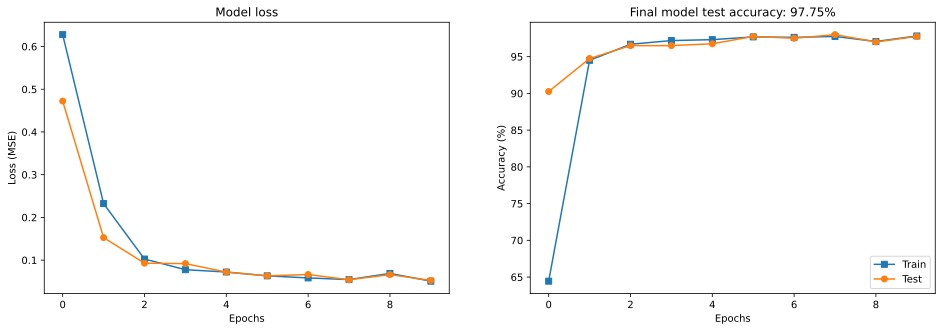

In [24]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [25]:
nUnits = np.round(np.linspace(5,500,20)).astype(int)

res = np.zeros((len(nUnits),4))
losses = np.zeros((len(nUnits),2))
acc = np.zeros((len(nUnits),2))

for i, nU in enumerate(nUnits):
    net, trainLoss, testLoss, trainAcc, testAcc = trainModel(nU)
    
    res[i,:] = [torch.mean(trainLoss), torch.mean(testLoss), torch.mean(trainAcc), torch.mean(testAcc)] 
    losses[i,0] = torch.mean(trainLoss)
    losses[i,1] = torch.mean(testLoss)
    
    acc[i, 0] = torch.mean(trainAcc)
    acc[i, 1] = torch.mean(testAcc)

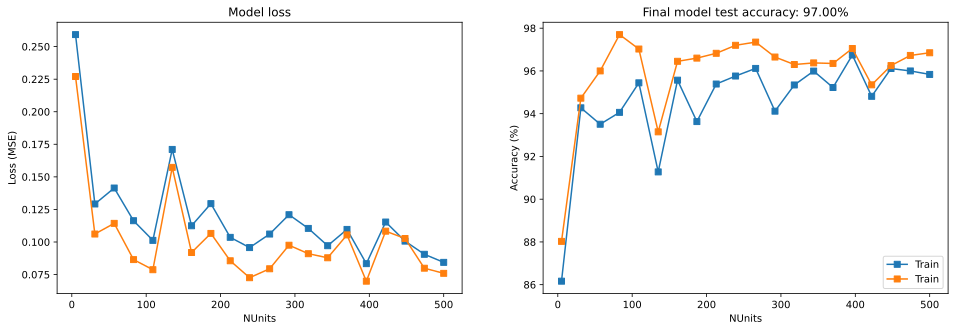

In [26]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(nUnits, res[:,:2],'s-',label='Train')
ax[0].set_xlabel('NUnits')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(nUnits, res[:,2:],'s-',label='Train')
ax[1].set_xlabel('NUnits')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

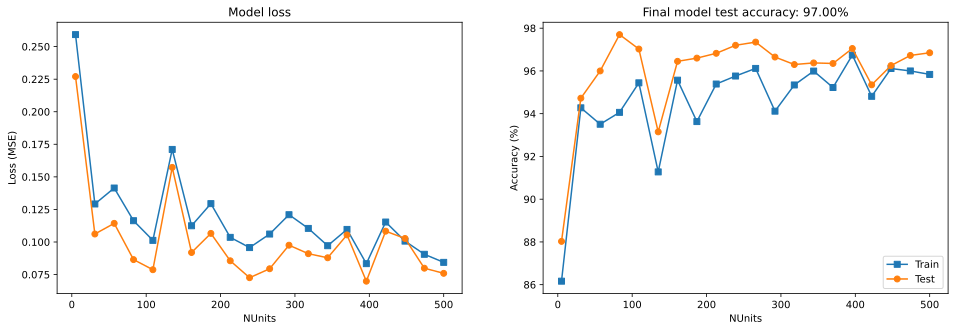

In [27]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(nUnits, losses[:,0],'s-',label='Train')
ax[0].plot(nUnits, losses[:,1],'o-',label='Test')
ax[0].set_xlabel('NUnits')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(nUnits, acc[:,0],'s-',label='Train')
ax[1].plot(nUnits, acc[:,1],'o-',label='Test')
ax[1].set_xlabel('NUnits')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [28]:
nUnits = np.round(np.linspace(5,500,20)).astype(int)

losses = np.zeros((len(nUnits),2))
acc = np.zeros((len(nUnits),2))
res = np.zeros((len(nUnits),4))

for i, nU in enumerate(nUnits):
    net, trainLoss, testLoss, trainAcc, testAcc = trainModel(nU)
    
    res[i,:] = [trainLoss[-1], testLoss[-1], trainAcc[-1], testAcc[-1]] 
    losses[i,0] = trainLoss[-1]
    losses[i,1] = testLoss[-1]
    
    acc[i, 0] = trainAcc[-1]
    acc[i, 1] = testAcc[-1]
    

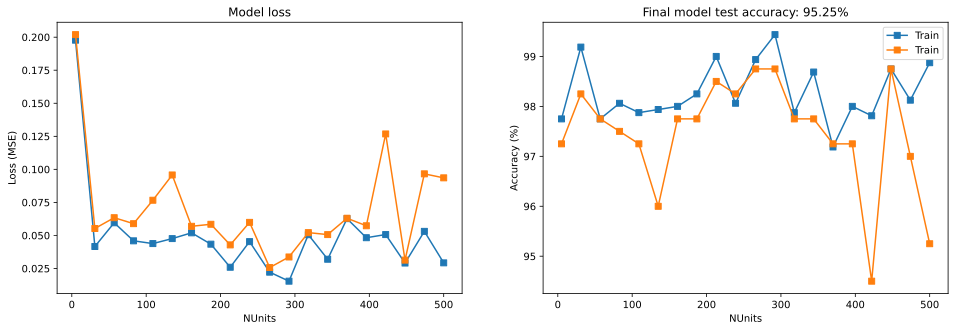

In [29]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(nUnits, res[:,:2],'s-',label='Train')
ax[0].set_xlabel('NUnits')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(nUnits, res[:,2:],'s-',label='Train')
ax[1].set_xlabel('NUnits')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

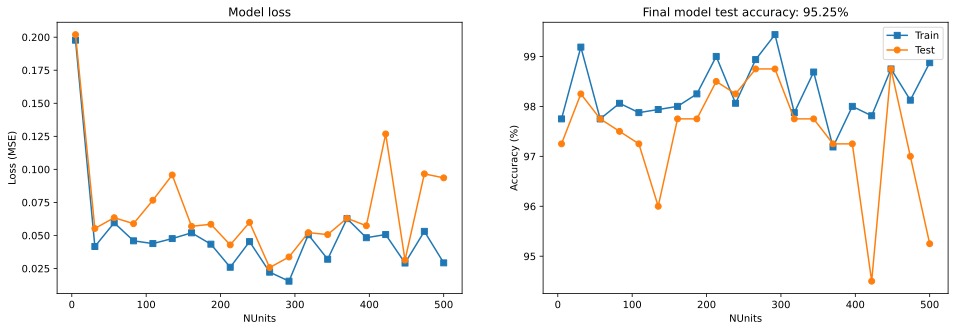

In [30]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(nUnits, losses[:,0],'s-',label='Train')
ax[0].plot(nUnits, losses[:,1],'o-',label='Test')
ax[0].set_xlabel('NUnits')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(nUnits, acc[:,0],'s-',label='Train')
ax[1].plot(nUnits, acc[:,1],'o-',label='Test')
ax[1].set_xlabel('NUnits')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Code Challenge - CNN - Can AE clean Occlusion?

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# model summary info
from torchsummary import summary

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
nGauss = 1000 # number of points per class
imgSize = 91 # 91x91 image

x = np.linspace(-4,4,imgSize) 
X,Y = np.meshgrid(x,x)

# sigma (arbitrary units) in different sizes
widths = np.linspace(2,20,nGauss)

# initializing tensors containing images
imgs = torch.zeros(nGauss, 1, imgSize, imgSize)
labels = torch.zeros(nGauss, 1, imgSize, imgSize)

for i in range(nGauss):
    
    # creating gaussians with random centers
    ro = 2*np.random.randn(2) # random offset
    G = np.exp(-((X - ro[0])**2 + (Y-ro[1])**2)/ (2*widths[i%2]**2))
    
    # add noise
    G += np.random.randn(imgSize, imgSize)/5
    
    # storing non-occluded img in labels first.
    labels[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
    
    # Adding a bar randomly
    i1 = np.random.choice(np.arange(2,28)) # starting location of bar
    i2 = np.random.choice(np.arange(2,6))  # width of bar
    
    if np.random.randn() > 0:
        G[i1:i1+i2, :] = 1
    else:
        G[:, i1:i1+i2] = 1
    
    # adding to tensor
    imgs[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)


In [3]:
def makeNet():
    
    class gaussNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            # encoding layer
            self.enc = nn.Sequential(
                nn.Conv2d(1,6,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                
                nn.Conv2d(6,4,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2)
            )
            
            # decoding layer
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(4,6,3,2),
                nn.ReLU(),
                nn.ConvTranspose2d(6,1,3,2), # final op of model
            )
            
        def forward(self, x):
            return self.dec(self.enc(x))
        
    
    net = gaussNet()
    lossfn = nn.MSELoss()
    optim = torch.optim.Adam(net.parameters(), lr=0.001)
    
    return net, lossfn, optim

 
torch.Size([10, 1, 91, 91])


Text(0.5, 1.0, 'Model output')

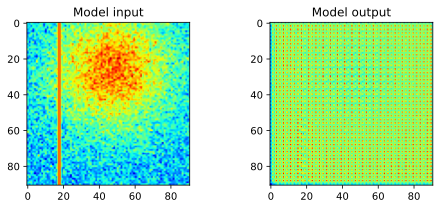

In [4]:
# test the model with one batch
net,lossfun,optimizer = makeNet()

yHat = net(imgs[:10,:,:,:])

# check size of output
print(' ')
print(yHat.shape)

# let's see how they look
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].imshow(torch.squeeze(imgs[0,0,:,:]).detach(),cmap='jet')
ax[0].set_title('Model input')
ax[1].imshow(torch.squeeze(yHat[0,0,:,:]).detach(),cmap='jet')
ax[1].set_title('Model output')

In [5]:
def trainModel():
    nEp = 1000
    
    net,lossfn,optim = makeNet()
    
    losses = torch.zeros(nEp)
    
    for i in range(nEp):
        
        pic = np.random.choice(nGauss, size=32, replace=False)
        X = imgs[pic,:,:,:]
        Y = labels[pic,:,:,:]
        
        yH = net(X)
        loss = lossfn(yH, Y)
        losses[i] = loss.item()
        
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    return losses, net

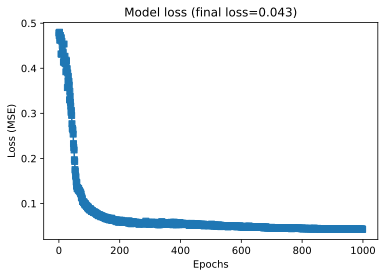

In [6]:
losses,net = trainModel()

plt.plot(losses,'s-',label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final loss=%.3f)'%losses[-1])

plt.show()

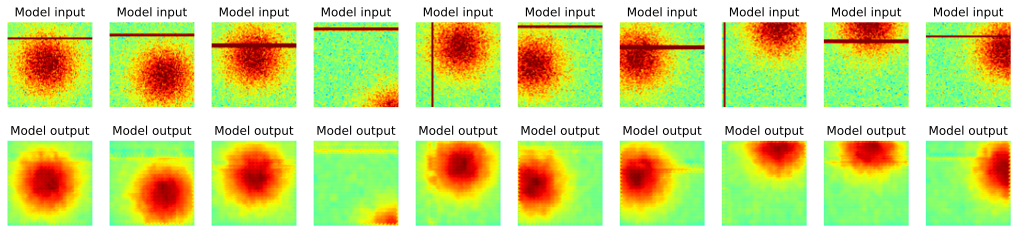

In [7]:
# visualize some images

pics2use = np.random.choice(nGauss,size=32,replace=False)
X = imgs[pics2use,:,:,:]
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(18,4))

for i in range(10):

    G = torch.squeeze( X[i,0,:,:] ).detach()
    O = torch.squeeze( yHat[i,0,:,:] ).detach()

    axs[0,i].imshow(G,vmin=-1,vmax=1,cmap='jet')
    axs[0,i].axis('off')
    axs[0,i].set_title('Model input')

    axs[1,i].imshow(O,vmin=-1,vmax=1,cmap='jet')
    axs[1,i].axis('off')
    axs[1,i].set_title('Model output')

plt.show()

In [8]:
x = np.linspace(-4,4,imgSize) 
X,Y = np.meshgrid(x,x)


# initializing tensors containing images
ip_data = torch.zeros(nGauss, 1, imgSize, imgSize)

for i in range(nGauss):
    
    # creating gaussians with random centers
    ro = 2*np.random.randn(2) # random offset
    G = np.exp(-((X - ro[0])**2 + (Y-ro[1])**2)/ (2*widths[i%2]**2))
    
    # add noise
    G += np.random.randn(imgSize, imgSize)/5
    
    # Adding a bar randomly
    i1 = np.random.choice(np.arange(2,28)) # starting location of bar
    i2 = np.random.choice(np.arange(2,6))  # width of bar
    
    if np.random.randn() > 0:
        G[i1:i1+i2, :] = 1
    else:
        G[:, i1:i1+i2] = 1
    
    # adding to tensor
    ip_data[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)


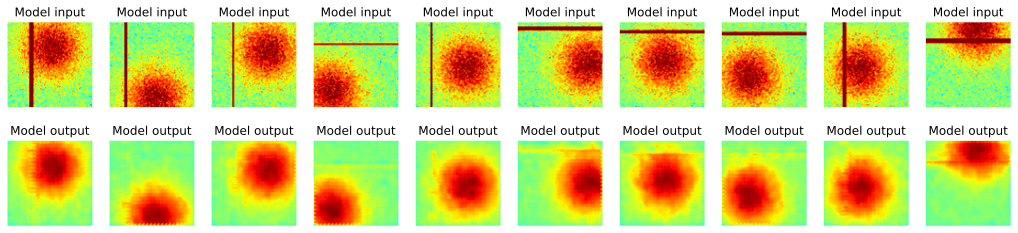

In [9]:
pics2use = np.random.choice(nGauss,size=32,replace=False)
data = ip_data[pics2use,:,:,:]
yHat = net(data)

fig,axs = plt.subplots(2,10,figsize=(18,4))

for i in range(10):

    G = torch.squeeze( data[i,0,:,:] ).detach()
    O = torch.squeeze( yHat[i,0,:,:] ).detach()

    axs[0,i].imshow(G,vmin=-1,vmax=1,cmap='jet')
    axs[0,i].axis('off')
    axs[0,i].set_title('Model input')

    axs[1,i].imshow(O,vmin=-1,vmax=1,cmap='jet')
    axs[1,i].axis('off')
    axs[1,i].set_title('Model output')

plt.show()

# Code Challenges - CNN - Custom Loss functions

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# model summary info
from torchsummary import summary

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

### Creating Gaussian blurs with Occluding bars

In [2]:
nGauss = 1000 # number of points per class
imgSize = 91 # 91x91 image

x = np.linspace(-4,4,imgSize) 
X,Y = np.meshgrid(x,x)

# sigma (arbitrary units) in different sizes
widths = np.linspace(2,20,nGauss)

# initializing tensors containing images
imgs = torch.zeros(nGauss, 1, imgSize, imgSize)

for i in range(nGauss):
    
    # creating gaussians with random centers
    ro = 2*np.random.randn(2) # random offset
    G = np.exp(-((X - ro[0])**2 + (Y-ro[1])**2)/ (2*widths[i%2]**2))
    
    # add noise
    G += np.random.randn(imgSize, imgSize)/5
    
    # Adding a bar randomly
    i1 = np.random.choice(np.arange(2,28)) # starting location of bar
    i2 = np.random.choice(np.arange(2,6))  # width of bar
    
    if np.random.randn() > 0:
        G[i1:i1+i2, :] = 1
    else:
        G[:, i1:i1+i2] = 1
    
    # adding to tensor
    imgs[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)


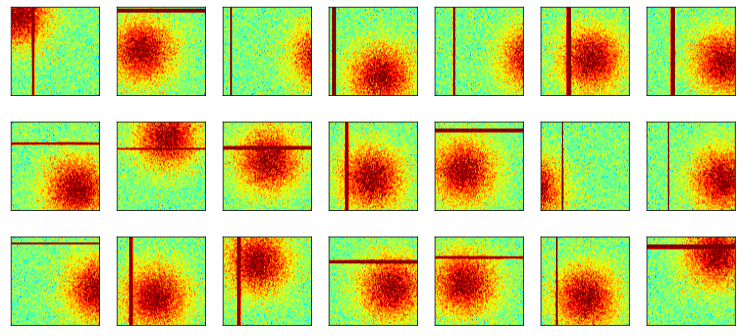

In [3]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss)
    G = np.squeeze( imgs[whichpic,:,:] )
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
#     ax.set_title('Class %s'%int(labels[whichpic].item()))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Custom Loss functions

In [4]:
class L1Loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, yH, y):
        return torch.mean(torch.abs(yH - y))
    
class L2Loss(nn.Module): # conjunctive loss
    def __init__(self):
        super().__init__()
        
    def forward(self, yH, y):
        return torch.mean((yH - y)**2) + torch.abs(torch.mean(yH))
    
class corrLoss(nn.Module): # conjunctive loss
    def __init__(self):
        super().__init__()
        
    def forward(self, yH, y):
        myH = torch.mean(yH)
        my = torch.mean(y)
        num = torch.sum((yH-myH)*(y-my))
        den = (torch.numel(y) - 1)*torch.std(yH)*torch.std(y)
        
        return -num/den

### Make DL Model

In [15]:
def makeNet():
    
    class gaussNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            # encoding layer
            self.enc = nn.Sequential(
                nn.Conv2d(1,6,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                
                nn.Conv2d(6,4,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2)
            )
            
            # decoding layer
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(4,6,3,2),
                nn.ReLU(),
                nn.ConvTranspose2d(6,1,3,2), # final op of model
            )
            
        def forward(self, x):
            return self.dec(self.enc(x))
        
    
    net = gaussNet()
    lossfn = corrLoss()
    optim = torch.optim.Adam(net.parameters(), lr=0.001)
    
    return net, lossfn, optim

In [16]:
# summary(net,(1,imgSize,imgSize))

In [17]:
def trainModel():
    nEp = 1000
    
    net,lossfn,optim = makeNet()
    
    losses = torch.zeros(nEp)
    
    for i in range(nEp):
        
        pic = np.random.choice(nGauss, size=32, replace=False)
        X = imgs[pic,:,:,:]
        
        yH = net(X)
        loss = lossfn(yH, X)
        losses[i] = loss.item()
        
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    return losses, net

In [18]:
losses,net = trainModel()

plt.plot(losses,'s-',label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final loss=%.3f)'%losses[-1])

plt.show()

In [19]:
# visualize some images

pics2use = np.random.choice(nGauss,size=32,replace=False)
X = imgs[pics2use,:,:,:]
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(18,4))

for i in range(10):

    G = torch.squeeze( X[i,0,:,:] ).detach()
    O = torch.squeeze( yHat[i,0,:,:] ).detach()

    axs[0,i].imshow(G,vmin=-1,vmax=1,cmap='jet')
    axs[0,i].axis('off')
    axs[0,i].set_title('Model input')

    axs[1,i].imshow(O,vmin=-1,vmax=1,cmap='jet')
    axs[1,i].axis('off')
    axs[1,i].set_title('Model output')

plt.show()